In [1]:
import shelve
import re
import os
from predict_price_helpers import *

In [2]:
with shelve.open('./predict-price.shelve', flag='r') as slf:
    for k,v in slf.items():
        print(k)
        globals()[k] = v
        if re.match('def\d+:', k) is not None:
            print(v)
            exec(v)

RESULTS_DIR
def0:
do_save = lambda fn: not(os.path.isfile(fn))
cfg
num_columns
cat_columns
models
df


In [3]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [4]:
# set figure defaults (needs to be in cell seperate from import sns)
plt.style.use([
    'default',
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/movshon.mplstyle",
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-notebook.mplstyle"
])

# Model: MLR with categorical

As MLR, but do one-hot-encoding

Use different scalers for different columns:  
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html  
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer  
p. 68 book: ML with sklearn & tf

## Prepare input

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import FeatureUnion

model_name = 'MLR with categorical'

cat_columns_reduced = list(np.setdiff1d(cat_columns, ['model', 'fuel']))
features = num_columns + cat_columns_reduced
# Can be reduced here

# list of lists with categories. Needed for column transformer
cats = list(df[cat_columns_reduced].apply(lambda x:pd.Series(x.unique()).dropna().tolist() + ['missing'], axis='index'))

# Use data frame not array
yX = df.dropna(subset=['price'])
# # only use young
# is_yng = yX.age/365.25 < 25
# yX = yX[is_yng]
X = yX.iloc[:,1:]
y = yX.iloc[:,0]
print(X.shape)
print(y.shape)


(9932, 29)
(9932,)


In [6]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)


(6952, 29)
(2980, 29)


In [7]:
# Create model

# Preprocessor: numerical features
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
)
# Preprocessor: categorical features
cat_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing', missing_values=np.NaN),
    OneHotEncoder(categories=cats),
)

# Preprocess: fuels
# list of all fuels is passed by using full data set! (X)
fuel_list = list(get_unique_fuels(merge_lpg_and_lpgtype(X.fuel)))
#fuel_list = ['benzine', 'diesel']
get_fuel_dummies = DummyfyFuel(fuel_list)


# Combine num and cat
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, pd.Index(num_columns)),
    ('categorical', cat_transformer, pd.Index(cat_columns_reduced)),
    ('onehot_fuel', get_fuel_dummies, 'fuel')
], verbose=True)

# full pipeline with preproc and mlr
mlr = make_pipeline(
    preprocessor,
    linear_model.LinearRegression()
)

# Target transformation: log transform price
def _pow10(y):
    return 10**y
pl = TransformedTargetRegressor(
    regressor=mlr,
    func=np.log10,
    inverse_func=pow10,
#    inverse_func=lambda y: 10**y,
#     func=lambda x:x,
#     inverse_func=lambda y: y,
#     inverse_func=np.exp,
)

models[model_name].update({'model':pl})

In [8]:
# fit
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)

[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.4s


In [9]:
# sanity check that target transformation has occured as expected
# y_pred_manual_transform = mlr.predict(X_test)
# assert all(np.log10(y_pred)-y_pred_manual_transform == 0)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [pl.regressor_.steps[-1][1].intercept_, *pl.regressor_.steps[-1][1].coef_]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':pl.score(X,y)})
models[model_name].update({'test R^2':pl.score(X_test,y_test)})
cv_results = cross_val_score(pl, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})

[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[Colum

In [10]:
# update features, by adding fuels
cat_columns_reduced += ['fuel']
cats += [fuel_list]


In [11]:
# Split betas per category feature.
idx_start = len(num_columns)+1
cat_betas = list()
for cat in cats:
    cat_betas += [betas[idx_start:idx_start+len(cat)]]
    idx_start += len(cat)
# Check if all betas are stored
assert cat_betas[0][0] == betas[len(num_columns)+1] # first cat beta follows numerical betas 
assert cat_betas[-1][-1] == betas[-1] # last

/home/tom/bin/satdatsci/Saturday-Datascience/results/MLR_with_categorical.png


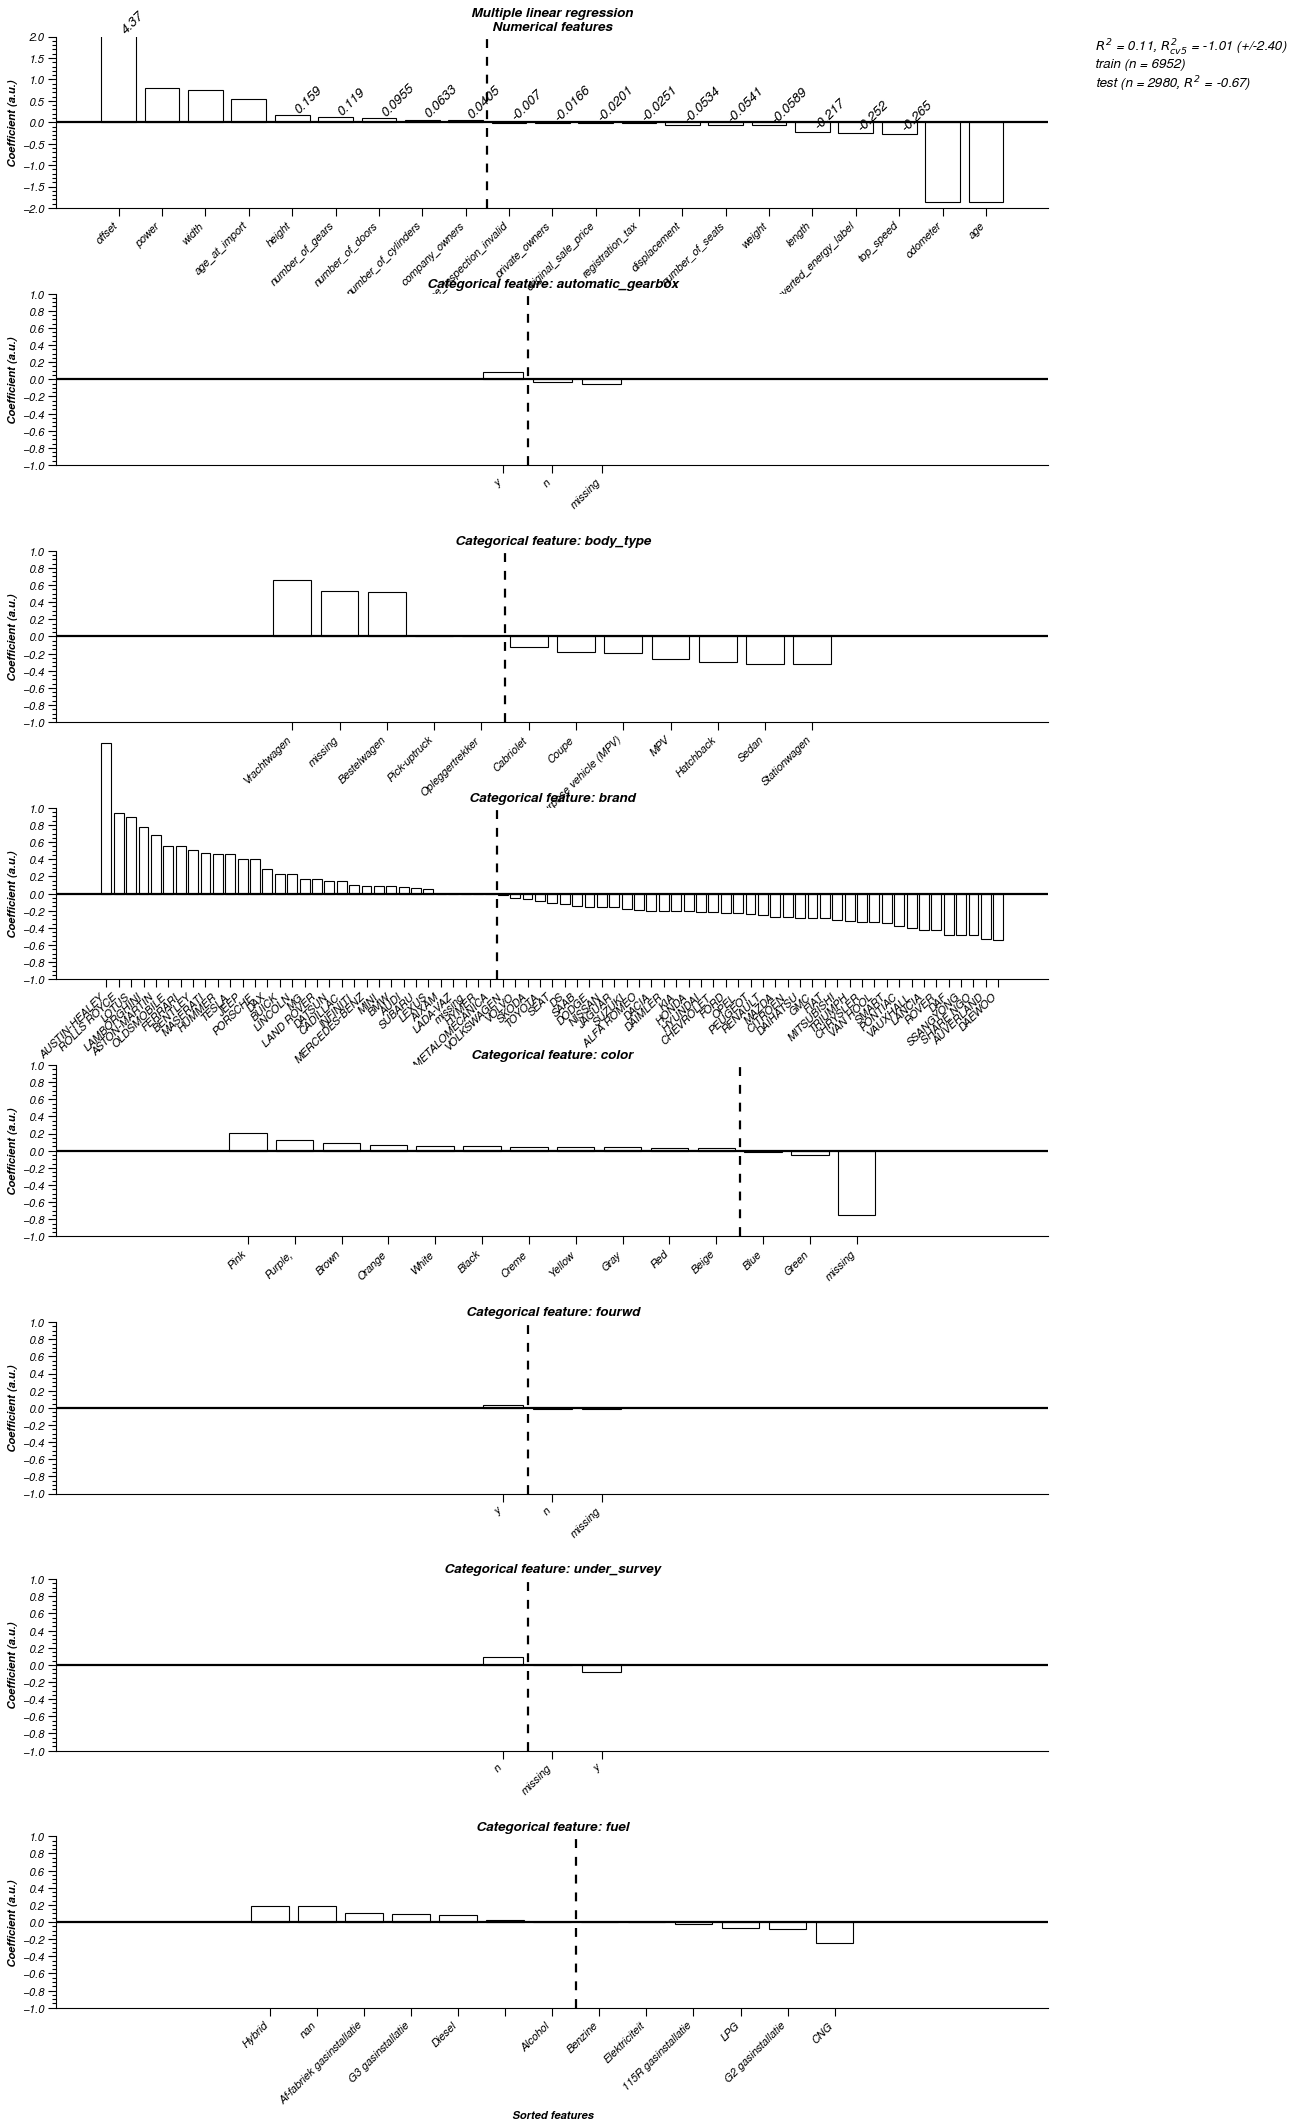

In [12]:
# plot coefficients

# plot numerical and catagorical in different subplots
n_plots = len(cat_columns_reduced) + 1
fig,axs=plt.subplots(
    nrows=n_plots,
    figsize=[16,4*n_plots]
)
plt.subplots_adjust(hspace=0.5)


# Plot numerical
ax = axs[0]
# sorted bar height
betas = models[model_name]['betas']
num_betas = betas[1:len(num_columns)+1]
x = ['offset'] + [features[i] for i in np.argsort(num_betas)[::-1]]
y = [betas[0]] + sorted(num_betas, reverse=True)

# plot bar
ax.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=True)

# add values when bar is small
for x_val, coef in zip(x,y):
    if np.abs(coef)<0.5:
        ax.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
ax.set_yticks(np.arange(-2,2.2,0.5))
ax.set_ylim(top=+2, bottom=-2)
# offset
x_val = x[0]
coef = y[0]
ax.text(x_val, 2, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')

# plot origin
x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
ax.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
ax.axhline(0, linewidth=2, linestyle='-', color='k')

# labels        
rot = 45
fsz = 10
ha = 'right'
ax.set_xticks(x)
ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.set_ylabel('Coefficient (a.u.)', style='italic')
ax.set_title('Multiple linear regression\nNumerical features', style='italic') 

# stats
xy=[ax.get_xlim()[1], ax.get_ylim()[1]]
ax.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    np.mean(models[model_name]['cv R^2']),
    np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')

# Plot categorical
for cat, cat_beta, cat_name, ax in zip(cats, cat_betas, cat_columns_reduced, axs[1:]):
    # sort by height
    x = [cat[i] for i in np.argsort(cat_beta)[::-1]]
    y = sorted(cat_beta, reverse=True)
    #x = cat
    #y = cat_beta
    # plot bar
    ax.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=False)

    # prettify
    ax.set_yticks(np.arange(-1,+1.1,0.2))
    ax.set_ylim(top=+1, bottom=-1)

    # plot origin
    x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
    ax.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
    ax.axhline(0, linewidth=2, linestyle='-', color='k')

    # labels
    rot = 45
    fsz = 10
    ha = 'right'
    ax.set_xticks(x)
    ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.set_title('Categorical feature: ' + cat_name, style='italic')
    ax.set_ylabel('Coefficient (a.u.)', style='italic')
    # add extra margin if bars are too wide (too little bars)
    if len(x) < 20:
        add_space = len(x) - 20
        xl = list(ax.set_xlim())
        xl[1] -= add_space/2
        xl[0] += add_space/2
        ax.set_xlim(xl)

# Label on bottom panel
ax = axs[-1]
ax.set_xlabel('Sorted features', style='italic')

# Save
file_name = f"{RESULTS_DIR}/{model_name.replace(' ','_')}.png"
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

In [13]:
fn = './predict-price.shelve'
with shelve.open(fn, flag='w') as slf:
    slf['models'] = models 
    print(f'Shelve file [{fn}] contains models:')
    for m in slf['models'].keys():
        print(f'\t{m}')

Shelve file [./predict-price.shelve] contains models:
	linear regression no cv
	linear regression log price young
	MLR reduced observations
	MLR impute median
	MLR with categorical
